In [1]:
import rosbag
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

In [3]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [4]:
bag = rosbag.Bag('waypoint/path_follow_waypoints.bag')
bag.get_type_and_topic_info()
content = []
# print(bag)
# input_steer = []
for topic, msg, _ in bag.read_messages(topics=['/state_estimator']):
    content.append(msg)
# print(content[0])

(35.55884736759321, 234.83843024257027, 100.90044536080102, 121.35317096979306)

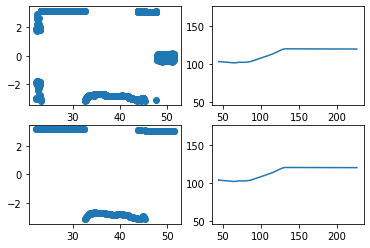

In [5]:
# estimator
x_estimator = []
y_estimator = []
yaw_estimator = []
waktu_estimator = []
# IMU + Amcl
x_coor = []
y_coor = []
yaw = []
waktu_yaw = []
# waktu (global)
waktu_amcl = []
# posisi amcl + waktu
for topic, msg, _ in bag.read_messages(topics=['/amcl_pose']):
    x_coor.append(msg.pose.pose.position.x)
    y_coor.append(msg.pose.pose.position.y)
    waktu_amcl.append(msg.header.stamp.to_sec())
# yaw dari IMU
for topic, msg, _ in bag.read_messages(topics=['/imu']):
    yaw.append(to_euler(msg.orientation.x,msg.orientation.y,msg.orientation.z,msg.orientation.w))
    waktu_yaw.append(msg.header.stamp.to_sec())
yaw = np.array(yaw)
yaw = yaw[:,2]
yaw = wrap_angle(yaw)
# data posisi + yaw dari estimator 
for topic, msg, _ in bag.read_messages(topics=['/state_estimator']):
    x_estimator.append(msg.x_est)
    y_estimator.append(msg.y_est)
    yaw_estimator.append(msg.yaw_gnss_fr)
    waktu_estimator.append(msg.header.stamp.to_sec())
yaw_estimator = wrap_angle(np.array(yaw_estimator))
# dari state estimator 
plt.subplot(221)
plt.scatter(waktu_estimator,yaw_estimator)
plt.subplot(222)
plt.plot(x_estimator,y_estimator)
plt.axis('equal')
# dari posisi dan yaw imu
plt.subplot(223)
plt.scatter(waktu_yaw,yaw)
plt.subplot(224)
plt.plot(x_coor,y_coor)
plt.axis('equal')
# plt.legend()
# plt.show()
# print(yaw)

In [6]:
# remove overlapped time stamp
time_tresh = 0

x_clean = np.copy(x_estimator)
y_clean = np.copy(y_estimator)
t_clean = np.copy(waktu_estimator)
yaw_clean = np.copy(yaw_estimator)

wp_x_clean = [x_clean[0]]
wp_y_clean = [y_clean[0]]
wp_yaw_clean = [yaw_clean[0]]
wp_t_clean = [t_clean[0]]

for i in range(1, t_clean.shape[0]):
    time_check = t_clean[i]-wp_t_clean[-1]
    if time_check > time_tresh:
    #if dist >= dst:
        wp_x_clean.append(x_clean[i])
        wp_y_clean.append(y_clean[i])
        wp_yaw_clean.append(yaw_clean[i])
        wp_t_clean.append(t_clean[i])
        
# diffx = wp_x[2:] - wp_x[:-2]
lanaya = np.array(wp_t_clean)
reset_waktu = wp_t_clean[0:]-wp_t_clean[0]
# lanaya[2]

print(len(waktu_estimator),lanaya.shape,len(wp_x_clean),len(wp_y_clean),len(wp_yaw_clean))

1469 (1249,) 1249 1249 1249


In [7]:
# Filter the waypoints and remove the outlier !
reverse_index = False
X = np.copy(wp_x_clean)
Y = np.copy(wp_y_clean)
# Y = Y + 1
T = np.copy(reset_waktu)
YAW = np.copy(wp_yaw_clean)
if reverse_index:

    YAW = YAW + np.pi
    YAW = wrap_angle(YAW)
    X = np.flip(X)
    Y = np.flip(Y)
    T = np.flip(T)
    YAW = np.flip(YAW)

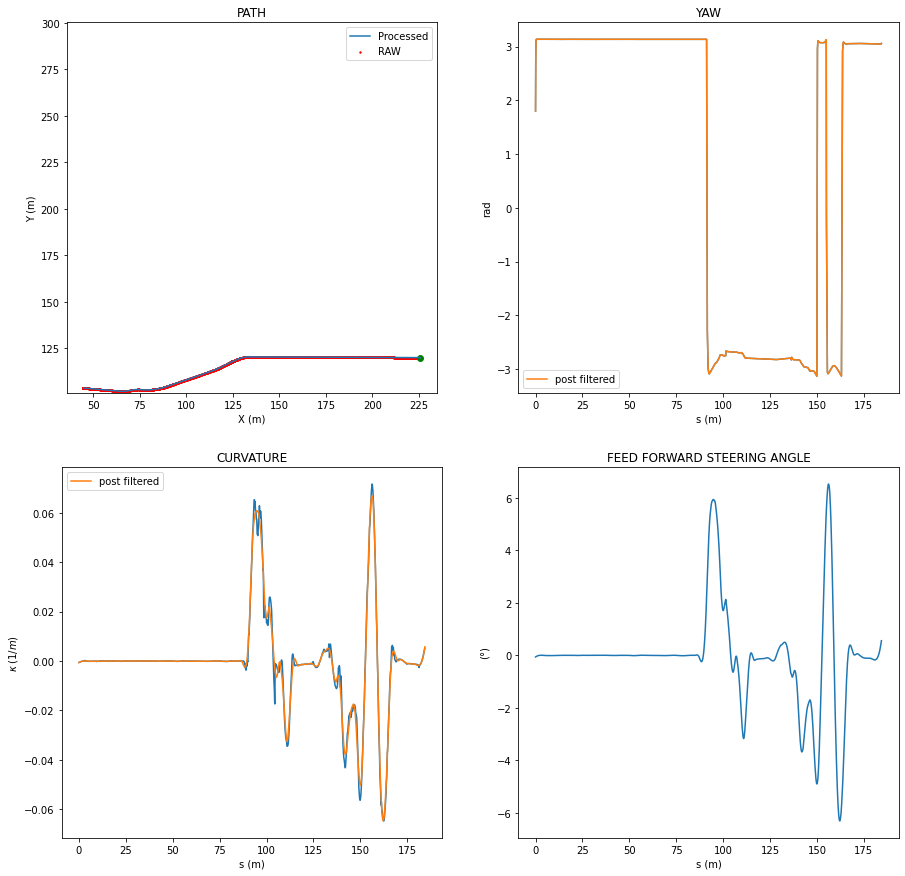

In [8]:
num_f = 61

# modif untuk trajectory
dst = 0.1 
# dst = 0.05

wp_x = [X[0]]
wp_y = [Y[0]]
wp_yaw = [YAW[0]]
wp_t = [T[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_yaw.append(wp_yaw[-1] + dst*(YAW[i] - wp_yaw[-1])/dist)
        wp_t.append(wp_t[-1] + dst*(T[i] - wp_t[-1])/dist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.array(wp_yaw)
temp = np.copy(wp_yaw)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]

wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

curvature = np.gradient(np.unwrap(wp_yaw_f), s)
curvaturef = savgol_filter(curvature, num_f, 3)
steer = np.arcsin(1.7 * curvaturef)*180/np.pi

# Limiting the steering angle
steer[steer > 35.] = 35
steer[steer < -28.] = -28.

wp_yaw = np.copy(temp)
# wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))
wp_yaw_f = np.copy(wp_yaw)

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x_coor, y_coor, color='red',s=2., label='RAW')
plt.scatter(wp_x[0], wp_y[0], c="g", s=35)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")
plt.axis('square')

plt.subplot(2,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

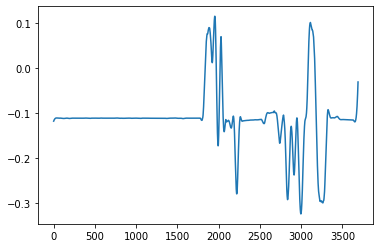

In [9]:
plt.plot(np.interp(steer,[-28,35],[-1,1]))

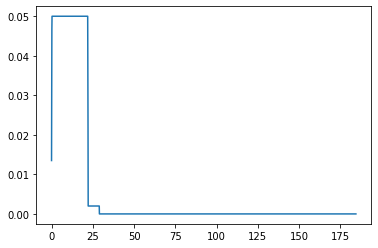

In [9]:
# # THROTTLEEEEE

# # Generate the velocity
v0 = 0.0135 #m/s ~ 1.8 km/jam
vstop = 0.002
vmax = 0.05 # 0.275 #m/s ~ 5.4 km/jam
accel = 0.005 #m/s2
num = wp_x_f.shape[0]
vel = [v0]
const = 7.
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
vel = np.array(vel)

for i in range(num):
    if s[i] >= 29:
        vel[i] = 0.0
    elif s[i] >= 22:
        vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

plt.plot(s, vel)

In [10]:
# adjust the trajectory time
wp_slow = np.array(wp_t)
wp_slow = wp_slow[0:]*(60/(wp_t[-1]-wp_t[0]))
# wp_slow

In [11]:
waypoints_np = np.empty((wp_x_f.shape[0], 6))
waypoints_np[:,0] = wp_x_f
waypoints_np[:,1] = wp_y_f
waypoints_np[:,2] = wp_yaw_f
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef
waypoints_np[:,5] = wp_slow

In [13]:
INTERP_DISTANCE_RES = 0.05 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [12]:
# np.save('Rabu_14_Apr_1', wp_interp)
np.save('Kamis_15_Apr_1', waypoints_np)
waypoints_np.shape

NameError: name 'wp_interp' is not defined

In [13]:
jreng=np.load('Kamis_15_Apr_1.npy')
jreng.shape
# tess = jreng[:,5]
# total_time = tess[-1]-tess[0]
# total_time
# tess

(1845, 6)

In [19]:
awal = np.array(wp_t)
total_time_awal = awal[-1]-awal[0]
# total_time_awal
awal

array([ 0.        ,  1.26243096,  1.36007097, ..., 15.452192  ,
       15.51510604, 15.66250488])